In [2]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 14.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import konlpy
from konlpy.tag import Kkma, Komoran, Okt, Hannanum
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

In [54]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/document(1).csv",encoding="euc-kr")
df

,Unnamed: 0,직업명,document
0,0,보건위생·환경검사원,"보건위생·환경검사원보건관리학과산업위생관리산업기사, 기사 기술사(국가기술)하위(25%..."
1,1,플랜트기계공학기술자,"플랜트기계공학기술자기계공학과0하위(25%) 4,144만원\n중위값 4,867만원\n..."
2,2,자연 및 문화해설사,"자연 및 문화해설사정확히 일치되는 학과정보가 없습니다.관광통역안내사(국가전문), 국..."
3,3,건축안전·환경·품질·에너지관리기술자,"건축안전·환경·품질·에너지관리기술자(안경)광학과건설안전산업기사, 기사, 기술사(국가..."
4,4,산업안전원,"산업안전원(안경)광학과산업안전산업기사, 기사(국가기술), 산업안전지도사(국가전문),..."
...,...,...,...
112,119,에너지관리전문가(EMS전문가),"에너지관리전문가(EMS전문가) 대학에서 전기, 기계, 화공, 건축설비 등의 전공이 ..."
113,120,신에너지전문가(수소연료전지전문가),"신에너지전문가(수소연료전지전문가) 수소연료전지 관련 학사 이상이나, 설계분야는 석박..."
114,121,재생에너지전문가,"재생에너지전문가 재생에너지전문가는 전기공학, 기계공학, 환경공학, 재료공학, 경영학..."
115,122,신재생에너지컨설턴트,"신재생에너지컨설턴트 신재생에너지컨설턴트로 종사하기 위해서는 대학에서 전기전자, 에너..."


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 형태소 분석 후 전처리

In [55]:
#'하다' 같은 불용어 제거를 위한 stopwords 정의
stopwords=['적','하다','성','및','등','있다','되다','하위','만원','중위','%','합니다','기사']

In [56]:
okt=Okt()

#품사태깅-> 필요없는 품사 지우기
corpuses1 = []
for i in df.document:
    word_list=[]
    for word,tagging in okt.pos(i, norm=True, stem=True):
        if tagging not in ['Alpha','Foreign','Number','Josa', 'Eomi', 'Punctuation']:
            if word not in stopwords:
                word_list.append(word)
    corpuses1.append(word_list)

In [59]:
df["corpuses1"]=corpuses1
df.head()

,Unnamed: 0,직업명,document,corpuses1
0,0,보건위생·환경검사원,"보건위생·환경검사원보건관리학과산업위생관리산업기사, 기사 기술사(국가기술)하위(25%...","[보건, 위생, 환경, 검사, 원, 보건관리, 학과, 산업위생, 관리, 산업, 기술..."
1,1,플랜트기계공학기술자,"플랜트기계공학기술자기계공학과0하위(25%) 4,144만원\n중위값 4,867만원\n...","[플랜트, 기계공학, 기술자, 기계공학, 값, 상위, 기술, 설계, 공간, 지각, ..."
2,2,자연 및 문화해설사,"자연 및 문화해설사정확히 일치되는 학과정보가 없습니다.관광통역안내사(국가전문), 국...","[자연, 문화, 설사, 정확하다, 일치, 학과, 정보, 없다, 관광통역안내사, 국가..."
3,3,건축안전·환경·품질·에너지관리기술자,"건축안전·환경·품질·에너지관리기술자(안경)광학과건설안전산업기사, 기사, 기술사(국가...","[건축, 안전, 환경, 품질, 에너지, 관리, 기술자, 안경, 광학, 건설, 안전,..."
4,4,산업안전원,"산업안전원(안경)광학과산업안전산업기사, 기사(국가기술), 산업안전지도사(국가전문),...","[산업, 안전원, 안경, 광학, 산업, 안전, 산업, 국가, 기술, 산업, 안전, ..."


In [60]:
#구두점 제거 후 string으로 변환해서 corpuses 2 컬럼으로 추가

import string

def remove_punctuation(input_string):
    # 구두점 제거하는 함수
    translator = str.maketrans('', '', string.punctuation)
    no_punct = input_string.translate(translator)
    return no_punct

def list_to_string_without_punctuation(input_list):
    # 리스트의 각 원소에 대해 구두점 없는 문자열로 변환
    result_list = [remove_punctuation(item) for item in input_list]
    # 리스트를 하나의 문자열로 합치기
    result_string = ' '.join(result_list)
    return result_string

In [61]:
corpuses2=[]
for i in corpuses1:
    result_string = list_to_string_without_punctuation(i)
    corpuses2.append(result_string)

df["corpuses2"]=corpuses2
df.head()

,Unnamed: 0,직업명,document,corpuses1,corpuses2
0,0,보건위생·환경검사원,"보건위생·환경검사원보건관리학과산업위생관리산업기사, 기사 기술사(국가기술)하위(25%...","[보건, 위생, 환경, 검사, 원, 보건관리, 학과, 산업위생, 관리, 산업, 기술...",보건 위생 환경 검사 원 보건관리 학과 산업위생 관리 산업 기술사 국가 기술 값 상...
1,1,플랜트기계공학기술자,"플랜트기계공학기술자기계공학과0하위(25%) 4,144만원\n중위값 4,867만원\n...","[플랜트, 기계공학, 기술자, 기계공학, 값, 상위, 기술, 설계, 공간, 지각, ...",플랜트 기계공학 기술자 기계공학 값 상위 기술 설계 공간 지각 력 장비 선정 기술 ...
2,2,자연 및 문화해설사,"자연 및 문화해설사정확히 일치되는 학과정보가 없습니다.관광통역안내사(국가전문), 국...","[자연, 문화, 설사, 정확하다, 일치, 학과, 정보, 없다, 관광통역안내사, 국가...",자연 문화 설사 정확하다 일치 학과 정보 없다 관광통역안내사 국가 전문 국내 여행 ...
3,3,건축안전·환경·품질·에너지관리기술자,"건축안전·환경·품질·에너지관리기술자(안경)광학과건설안전산업기사, 기사, 기술사(국가...","[건축, 안전, 환경, 품질, 에너지, 관리, 기술자, 안경, 광학, 건설, 안전,...",건축 안전 환경 품질 에너지 관리 기술자 안경 광학 건설 안전 산업 기술사 국가 기...
4,4,산업안전원,"산업안전원(안경)광학과산업안전산업기사, 기사(국가기술), 산업안전지도사(국가전문),...","[산업, 안전원, 안경, 광학, 산업, 안전, 산업, 국가, 기술, 산업, 안전, ...",산업 안전원 안경 광학 산업 안전 산업 국가 기술 산업 안전 지도사 국가 전문 인간...


In [65]:
df.to_csv("corpus_dfdfdf.csv",encoding="utf-8")

## K-means 군집분석

In [66]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df.corpuses2)
tfidf_matrix.shape

(117, 2809)

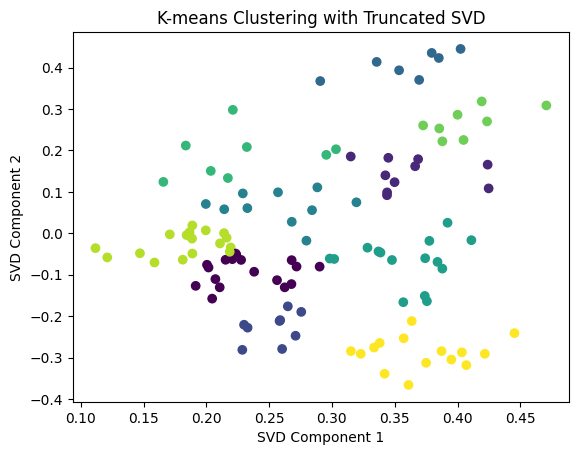

In [67]:
# 차원 축소 (Truncated SVD 사용)
n_components = 2  # 2차원으로 축소
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(tfidf_matrix)

# K-means 클러스터링
n_clusters = 10  # 클러스터 개수
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0, n_init=10)
kmeans.fit(svd_matrix)

# 클러스터링 결과를 데이터프레임에 추가
df['cluster'] = kmeans.labels_
# 시각화
plt.scatter(x=svd_matrix[:, 0], y=svd_matrix[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering with Truncated SVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.show()

## 최적의 K값 찾기

In [24]:
from sklearn.metrics import silhouette_score

sil = []
k_values = []
for i in range(2, 15):  # 클러스터 개수를 2부터 12까지 시도
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, random_state=0)
    kmeans.fit(svd_matrix)
    silhouette_avg = silhouette_score(svd_matrix, kmeans.labels_)  # Silhouette Coefficient 계산
    sil.append(silhouette_avg)
    k_values.append(i)

# 가장 높은 Silhouette Coefficient를 가지는 K의 값 찾기
max_sil_index = sil.index(max(sil))
optimal_k = k_values[max_sil_index]
print("Optimal number of clusters (K):", optimal_k)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Optimal number of clusters (K): 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'K에 따른 Silhouette Coefficient')

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47480 (\N{HANGUL SYLL

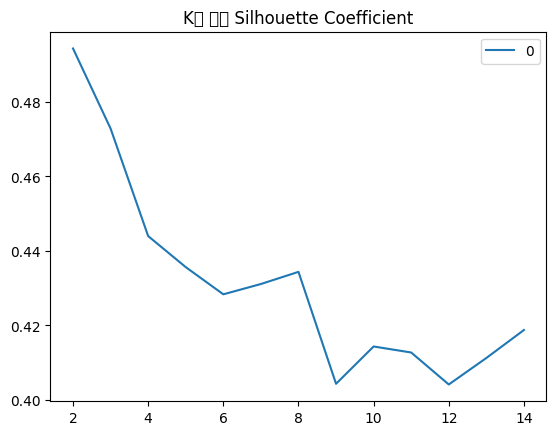

In [25]:
silhouette=pd.DataFrame(sil,k_values)
silhouette.plot()
plt.title("K에 따른 Silhouette Coefficient")

# 군집 내 유사도

In [68]:
df

,Unnamed: 0,직업명,document,corpuses1,corpuses2,cluster
0,0,보건위생·환경검사원,"보건위생·환경검사원보건관리학과산업위생관리산업기사, 기사 기술사(국가기술)하위(25%...","[보건, 위생, 환경, 검사, 원, 보건관리, 학과, 산업위생, 관리, 산업, 기술...",보건 위생 환경 검사 원 보건관리 학과 산업위생 관리 산업 기술사 국가 기술 값 상...,7
1,1,플랜트기계공학기술자,"플랜트기계공학기술자기계공학과0하위(25%) 4,144만원\n중위값 4,867만원\n...","[플랜트, 기계공학, 기술자, 기계공학, 값, 상위, 기술, 설계, 공간, 지각, ...",플랜트 기계공학 기술자 기계공학 값 상위 기술 설계 공간 지각 력 장비 선정 기술 ...,1
2,2,자연 및 문화해설사,"자연 및 문화해설사정확히 일치되는 학과정보가 없습니다.관광통역안내사(국가전문), 국...","[자연, 문화, 설사, 정확하다, 일치, 학과, 정보, 없다, 관광통역안내사, 국가...",자연 문화 설사 정확하다 일치 학과 정보 없다 관광통역안내사 국가 전문 국내 여행 ...,4
3,3,건축안전·환경·품질·에너지관리기술자,"건축안전·환경·품질·에너지관리기술자(안경)광학과건설안전산업기사, 기사, 기술사(국가...","[건축, 안전, 환경, 품질, 에너지, 관리, 기술자, 안경, 광학, 건설, 안전,...",건축 안전 환경 품질 에너지 관리 기술자 안경 광학 건설 안전 산업 기술사 국가 기...,7
4,4,산업안전원,"산업안전원(안경)광학과산업안전산업기사, 기사(국가기술), 산업안전지도사(국가전문),...","[산업, 안전원, 안경, 광학, 산업, 안전, 산업, 국가, 기술, 산업, 안전, ...",산업 안전원 안경 광학 산업 안전 산업 국가 기술 산업 안전 지도사 국가 전문 인간...,7
...,...,...,...,...,...,...
112,119,에너지관리전문가(EMS전문가),"에너지관리전문가(EMS전문가) 대학에서 전기, 기계, 화공, 건축설비 등의 전공이 ...","[에너지, 관리, 전문가, 전문가, 대학, 전기, 기계, 화공, 건축, 설비, 전공...",에너지 관리 전문가 전문가 대학 전기 기계 화공 건축 설비 전공 유리하다 업체 따라...,9
113,120,신에너지전문가(수소연료전지전문가),"신에너지전문가(수소연료전지전문가) 수소연료전지 관련 학사 이상이나, 설계분야는 석박...","[신, 에너지, 전문가, 수, 소, 연료, 전, 지, 전문가, 수, 소, 연료, 전...",신 에너지 전문가 수 소 연료 전 지 전문가 수 소 연료 전지 관련 학사 이상 설계...,9
114,121,재생에너지전문가,"재생에너지전문가 재생에너지전문가는 전기공학, 기계공학, 환경공학, 재료공학, 경영학...","[재생에너지, 전문가, 재생에너지, 전문가, 전기공학, 기계공학, 환경공학, 재료공...",재생에너지 전문가 재생에너지 전문가 전기공학 기계공학 환경공학 재료공학 경영학 행정...,9
115,122,신재생에너지컨설턴트,"신재생에너지컨설턴트 신재생에너지컨설턴트로 종사하기 위해서는 대학에서 전기전자, 에너...","[신재생에너지, 컨설턴트, 신재생에너지, 컨설턴트, 종사, 위, 대학, 전기, 전자...",신재생에너지 컨설턴트 신재생에너지 컨설턴트 종사 위 대학 전기 전자 에너지공학 전공...,9


[[1.         0.99878955 0.99533324 0.99990873 0.99928964 0.99013393
  0.95240268 0.97698385 0.98813101 0.99999985 0.96123664 0.99822214
  0.98273721 0.99992741 0.9999895  0.92813621 0.99357634 0.99622464]
 [0.99878955 1.         0.98938195 0.99803382 0.99993373 0.98204303
  0.93625532 0.96530886 0.97937902 0.99876269 0.94651083 0.9999456
  0.97244758 0.99812439 0.99900451 0.90870307 0.98680739 0.99074864]
 [0.99533324 0.98938195 1.         0.99654614 0.9909896  0.99903483
  0.97737458 0.99300867 0.99834294 0.99538549 0.98335749 0.9878121
  0.9960037  0.99642366 0.99488049 0.95972509 0.99985957 0.99995271]
 [0.99990873 0.99803382 0.99654614 1.         0.99868926 0.99193673
  0.9564344  0.97977669 0.99011625 0.99991592 0.96487414 0.99732574
  0.98514709 0.99999893 0.9998363  0.93308074 0.99501457 0.99730662]
 [0.99928964 0.99993373 0.9909896  0.99868926 1.         0.98414987
  0.94023787 0.96825094 0.98164002 0.99926902 0.95016289 0.99975924
  0.97506696 0.99876303 0.99945187 0.91344869 

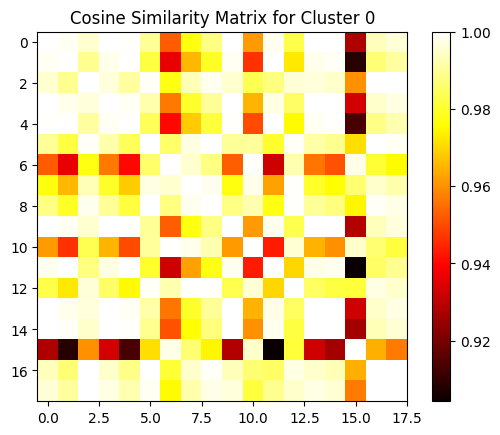

In [69]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# 특정 클러스터 선택 (예: 클러스터 0)
cluster_idx = 0
cluster_data = svd_matrix[df['cluster'] == cluster_idx]

# 코사인 유사도 계산
cosine_sim_matrix = cosine_similarity(cluster_data)
print(cosine_sim_matrix)

# 코사인 유사도 매트릭스 시각화
plt.imshow(cosine_sim_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Cosine Similarity Matrix for Cluster {cluster_idx}')
plt.show()

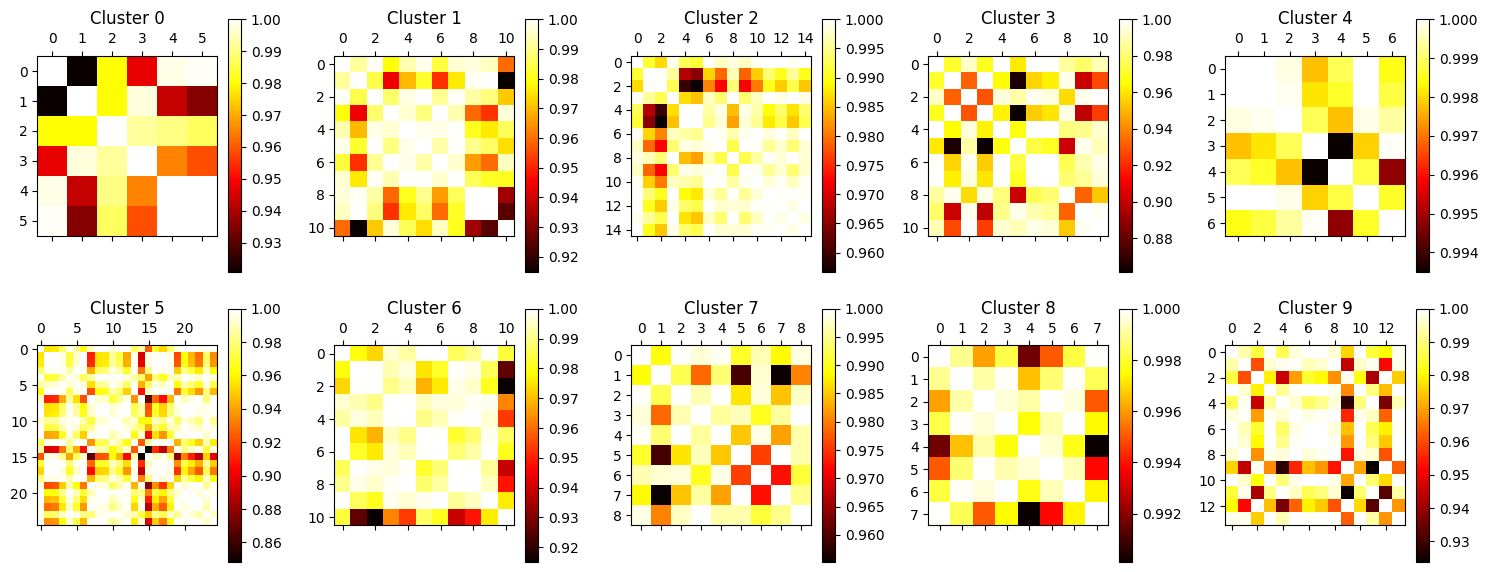

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# K-means 클러스터링 결과 및 SVD 결과 사용
n_clusters = 10
cosine_matrices = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# 각 군집에 대한 코사인 유사도 매트릭스 계산 및 시각화
for i in range(n_clusters):
    cluster_data = svd_matrix[df['cluster'] == i]
    cosine_sim_matrix = cosine_similarity(cluster_data)
    cosine_matrices.append(cosine_sim_matrix)

    ax = axes[i//5, i%5]
    cax = ax.matshow(cosine_sim_matrix, cmap='hot')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'Cluster {i}')

plt.tight_layout()
plt.show()

## 사용자 정보 받아서 군집 예측하기

In [78]:
new_data = {
    'name': ['장정우'],
    'document': ['에너지공학과 전기기사, 정보통신, 에너지 개발 에너지공학과를 졸업하고 신재생에너지에 대한 공부를 했다. 공학과 기술, 산수와 수학을 공부하며 태양광에너지를 전기로 바꾸는 공부를 했다. 여러 재생에너지를 사용하는 곳에서 전기를 생산하고 공급할 수 있는 장비를 개발하고 관리하는 일을 하고 싶다. 수리, 논리력이 좋아서 장비 개발과 관리에 자신이 있고 문제를 논리적으로 해결할 수 있다. 신재생에너지를 통해 환경보호에 기여하는 성취감을 얻고 싶다. 외향적 논리적 현실적 현실형 탐구형 진취형 고용안정 성취 인정 지적추구 화학 건축 및 설계 물리 공학과 기술 산수와 수학 상품 제조 및 공정 영어"']
}

new_df = pd.DataFrame(new_data)

#사용자 정보 전처리
new_corpus=[]
for word,tagging in okt.pos(str(new_df.document[0]), norm=True, stem=True):
    if tagging not in ['Alpha','Foreign','Number','Josa', 'Eomi', 'Punctuation']:
        if word not in stopwords:
            new_corpus.append(word)

new_df["corpus1"]=[new_corpus]
new_df["corpus2"]=list_to_string_without_punctuation(new_corpus)
new_df

,name,document,corpus1,corpus2
0,장정우,"에너지공학과 전기기사, 정보통신, 에너지 개발 에너지공학과를 졸업하고 신재생에너지에...","[에너지공학, 전기기사, 정보, 통신, 에너지, 개발, 에너지공학, 졸업, 신재생에...",에너지공학 전기기사 정보 통신 에너지 개발 에너지공학 졸업 신재생에너지 대한 공부 ...


In [79]:
# TF-IDF 변환
new_tfidf_matrix = vectorizer.transform(new_df.corpus2)

#차원축소
new_svd_matrix = svd.transform(new_tfidf_matrix)

# K-means 모델을 사용하여 새로운 데이터의 군집 예측
cluster_prediction = kmeans.predict(new_svd_matrix)
print("군집 예측:", cluster_prediction)

# 같은 군집의 직업명 조회
if cluster_prediction.size > 0:
    cluster_index = cluster_prediction[0]
    jobnames = df[df['cluster'] == cluster_index]['직업명'].values.tolist()
    print("추천 직업:", jobnames)
else:
    print("군집 예측 결과가 없습니다.")


군집 예측: [4]
추천 직업: ['자연 및 문화해설사', '축산학·수의학연구원', '지질학연구원', '냉동·냉장·공조기설치·정비원', '정밀 농업기술자', nan, '환경영향평가원', '녹색건축전문가', '배터리 조립 유지보수 기술자', '환경 감측원']


## 사용자 정보와 예측 군집 간 유사도 분석

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산
cosine_sim = cosine_similarity(new_svd_matrix, svd_matrix[df['cluster'] == cluster_prediction[0]])

# 코사인 유사도 출력
print("코사인 유사도:", cosine_sim)

코사인 유사도: [[0.89374091 0.94547037 0.90692453 0.95611462 0.98547925 0.91791682
  0.90715992 0.99999264 0.96603734 0.94833374]]


In [81]:
cluster_center = kmeans.cluster_centers_[cluster_prediction[0]]
cluster_center
cosine_sim = cosine_similarity([cluster_center], new_svd_matrix)
cosine_sim

array([[0.95238867]])

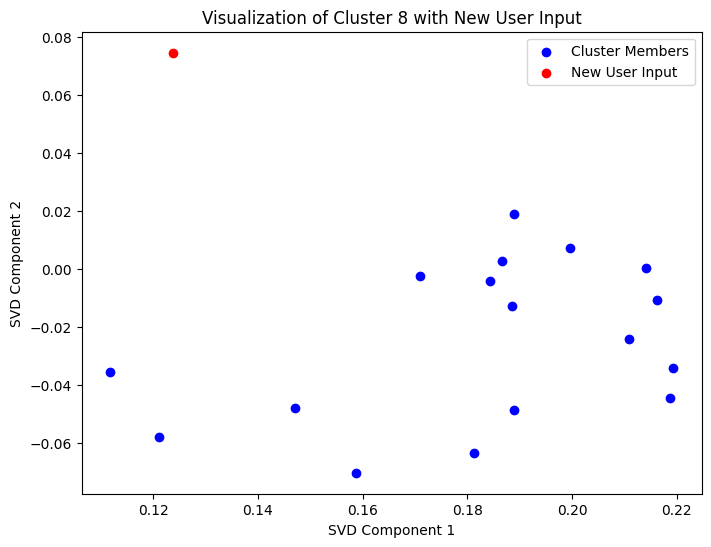

In [76]:
import matplotlib.pyplot as plt

# 사용자의 군집 예측 결과
cluster_prediction = kmeans.predict(new_svd_matrix)

# 기존 군집 데이터
cluster_data = svd_matrix[df['cluster'] == cluster_prediction[0]]

# 새로운 사용자 데이터
new_user_data = new_svd_matrix

# 군집 시각화
plt.figure(figsize=(8, 6))
plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c='blue', label='Cluster Members')
plt.scatter(new_user_data[0, 0], new_user_data[0, 1], c='red', label='New User Input')
plt.title(f'Visualization of Cluster {cluster_prediction[0]} with New User Input')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.show()

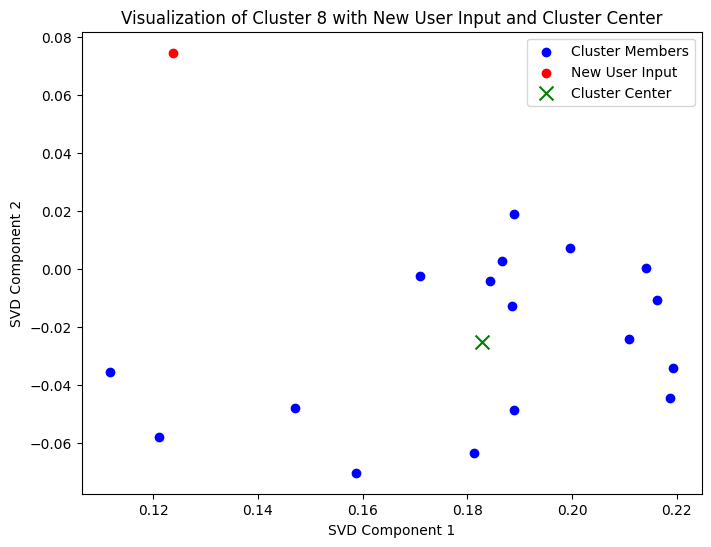

In [77]:
import matplotlib.pyplot as plt

# 사용자의 군집 예측 결과
cluster_prediction = kmeans.predict(new_svd_matrix)

# 기존 군집 데이터
cluster_data = svd_matrix[df['cluster'] == cluster_prediction[0]]

# 새로운 사용자 데이터
new_user_data = new_svd_matrix

# 군집 중심
cluster_center = kmeans.cluster_centers_[cluster_prediction[0]]

# 군집 시각화
plt.figure(figsize=(8, 6))
plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c='blue', label='Cluster Members')
plt.scatter(new_user_data[0, 0], new_user_data[0, 1], c='red', label='New User Input')
plt.scatter(cluster_center[0], cluster_center[1], c='green', marker='x', s=100, label='Cluster Center')
plt.title(f'Visualization of Cluster {cluster_prediction[0]} with New User Input and Cluster Center')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.show()


## 직업 위치정보 전처리

In [8]:
import folium
import json
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv('location.csv')
df

In [ ]:
#도로명 주소 변환
address=df['주소']
for i in range(len(address)):
    a = address[i].split(' ')
    address[i] = " ".join(a[0:4])
print(address)

In [ ]:
#geopy 라이브러리
from geopy.geocoders import Nominatim
geo_local = Nominatim(user_agent='South Korea')

# 위도, 경도 반환하는 함수
def geocoding(address):
    try:
        geo = geo_local.geocode(address)
        x_y = [geo.latitude, geo.longitude]
        return x_y

    except:
        return [0,0]

In [ ]:
#주소 위도,경도로 변환
latitude = []
longitude =[]

for i in address:
    latitude.append(geocoding(i)[0])
    longitude.append(geocoding(i)[1])
    
print(latitude)
print(longitude)

In [ ]:
#새로운 데이터 프레임 생성 
address_df = pd.DataFrame({'직업명': df['직업명'],'직업종류':df['직업종류'],'주소':address,'위도':latitude,'경도':longitude})

In [ ]:
#회사명 컬럼 추가 
address_df['회사명']=df['회사명']
address_df.head(15)

In [ ]:
#위도,경도 0인 행 삭제
zero_cols = ['위도', '경도'] 
address_df = address_df[~(address_df[zero_cols] == 0).any(axis=1)]
address_df = address_df.reset_index(drop=True)
print(address_df)

In [ ]:
#직업명 0인 행 삭제
df = address_df[address_df['직업명'] != '0']
df = address_df.reset_index(drop=True)
print(df)

In [ ]:
#새로운 csv 파일에 저장
df.to_csv('locations.csv', index=False)

## 지도에 Markup

In [2]:
from branca.element import Figure
import pandas as pd

In [3]:
locations=pd.read_csv('locations.csv')

In [4]:
#딕셔너리
grouped_lat = locations.groupby('직업명')['위도'].apply(list).to_dict()
grouped_long = locations.groupby('직업명')['경도'].apply(list).to_dict()
grouped_comp=locations.groupby('직업명')['회사명'].apply(list).to_dict()

In [9]:
#추천받은 직업 이름 jobnames
job_locations = {}
colors = ['red', 'blue', 'orange', 'green', 'pink', 'purple', 'lightblue', 'lightgreen','beige','lightred','cadetblue','lightgray']
j=0

fig = Figure(width=800,height=550)
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

for jobname in jobnames:
    job_latitudes = grouped_lat.get(jobname, [])
    job_longitudes = grouped_long.get(jobname, [])
    company_names = grouped_comp.get(jobname,[])

    if job_latitudes or job_longitudes:
        job_locations[jobname] = {'latitude': job_latitudes, 'longitude': job_longitudes}
        j+=1

    for lat, lon, comp in zip(job_latitudes, job_longitudes,company_names):
        popup_text = f"""
                <div style="width: 200px; height: 60px;">
                <h4>{jobname}</h4>
                <p>{comp}</p>
            </div>
        """

        folium.Marker([lat,lon],popup=popup_text,icon=folium.Icon(color=colors[j-1])).add_to(m)

m

#print(job_locations)